In [2]:
import twitter, datetime
import json
import pymongo
from dotenv import load_dotenv 
import os 
import pandas
import preprocessor as p
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

load_dotenv()                  

mongo = os.environ.get('mongo')
db = os.environ.get('db')
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]
hashtags = {'JohnsonAndJohnsonVaccine': ['JnJVaccine', 'JnJ', 'JohnsonAndJohnsonVaccine'],
            'PfizerVaccine': ['PfizerVaccine', 'Pfizer'],
            'ModernaVaccine': ['ModernaVaccine', 'Moderna'],
            'Vaccinated': ['Vaccinated']
        }
# hashtags = {'ModernaVaccine': ['ModernaVaccine', 'Moderna'],
#             'Vaccinated': ['Vaccinated'] }

def oauth_login():
    '''
    A static method to authenticate user
    It uses OAuth2.0 specification which takes a bearer token to authenticate user
    '''

    CONSUMER_KEY = os.environ.get('CONSUMER_KEY')
    CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET')
    BEARER_TOKEN= os.environ.get('BEARER_TOKEN')
    
    auth = twitter.OAuth2(CONSUMER_KEY, CONSUMER_SECRET, BEARER_TOKEN)
    api = twitter.Twitter(auth=auth)
    return api

def clean_results(result, topic):
    '''
    To take required text for NLP, may change later as per the requirement
    '''
    final = []
    for arr in result["statuses"]:
        obj = dict()
        obj["tweet"] = arr["text"]
        obj["id"] = arr["id_str"]
        obj["name"] = arr["user"]["name"]
        obj["location"] = arr["user"]["location"]
        obj["topic"] = topic
        obj["created_at"] = arr["created_at"]
        obj["processed_on"] = datetime.datetime.now().isoformat(' ', 'seconds')
        final.append(obj)
    return final

def save_tweets_csv(tweets, topic):
    '''
    This method will help us on saving tweets
    '''
    try:
        fieldnames = list(tweets[0].keys())
        output_dir = os.path.join('data', 'csv')
        output_file = os.path.join(output_dir, topic+'.csv')
        if not os.path.exists(output_file):
            open(output_file, 'w').close()
        file_empty = os.stat(output_file).st_size == 0
        with open(output_file, mode='a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
            if file_empty:
                writer.writeheader() 
            writer.writerows(tweets)
        print("done inserting")
    except Exception as e:
        print(e)

def query_tweet(query, count, topic):
    '''
    Queries and finds tweet for different hashtags/topic, it will keep on searching until it finds total count
    '''
    api = oauth_login()
    meta = query.split("-RT")[0].split('#')[1]
    result = api.search.tweets(q=query, count=500)
    print(result["search_metadata"])
    save_tweets_csv(clean_results(result, meta), topic)
    result_count = result["search_metadata"]["count"]
    next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
    while result_count < count:
        result = api.search.tweets(q=query, include_entities='true',max_id=next_max_id, count=500 )
        print(result["search_metadata"])
        print(result_count)
        save_tweets_csv(clean_results(result, meta), topic)
        result_count += result["search_metadata"]["count"]
        if "next_results" in result["search_metadata"]:
            next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
        else:
            break
        
def get_docs_csv():   
    client = pymongo.MongoClient(mongo)
    database = client[db]
    for col in topics:
        coll = database[col] 
        try:
            result = coll.find()
            
            fieldnames = list(result[0].keys())
            fieldnames.remove('_id')

            output_dir = os.path.join('data', 'csv')
            output_file = os.path.join(output_dir, col+'.csv')
            with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
                writer.writeheader()
                writer.writerows(result)

        except Exception as e:
            print(e)

def remove_punctuations(text):
    punct =['%','/',':','\\','&amp;','&',';']
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

def get_value_counts(col_name, analyzer_name, tweets_df):
    '''
    This function returns count of the dataset passed, it uses pands library to do the same
    '''
    count = pandas.DataFrame(tweets_df[col_name].value_counts())
    percentage = pandas.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    counts = pandas.concat([count, percentage], axis = 1)
    counts = counts.reset_index()
    counts.columns = ['sentiment', 'counts', 'percentage']
    counts.sort_values('sentiment', inplace = True)
    counts['percentage'] = counts['percentage'].apply(lambda x: round(x,2))
    counts = counts.reset_index(drop = True)
    counts['analyzer'] = analyzer_name
    return counts

def fetch_tweets():
    '''
    This method fetches and stores the tweets for the last seven days and store it in the mongodb
    '''
    try:
        for key in hashtags.keys():
            for topic in hashtags[key]:
                query_tweet("#"+ topic+" -RT AND lang:en", 10000, key)
        print("Done fetching tweets")
    except Exception as e:
        print(e)

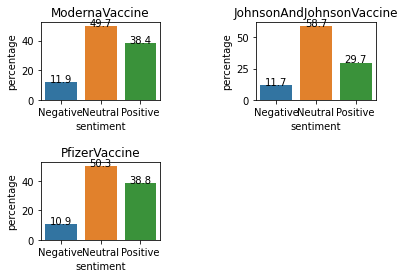

In [4]:
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine", "Vaccinated"]
# topics = ["ModernaVaccine"]
final_bar = []
result_copy = dict()
for topic in topics:          
        file_dir = os.path.join('data', 'csv')
        file = os.path.join(file_dir, topic+'.csv')
        result = pandas.read_csv(file)
        result.sort_values(by="created_at")
        result_copy[topic] = result.copy()
        result_copy[topic]['tweet_cleaned'] = result_copy[topic]['tweet'].apply(lambda x: p.clean(x))
        result_copy[topic].drop_duplicates(subset='tweet_cleaned', keep='first', inplace=True)

        # remove punctuations
        result_copy[topic]['tweet_cleaned'] = result_copy[topic]['tweet_cleaned'].apply(lambda x: remove_punctuations(x))

        # Drop tweets which have empty text field
        result_copy[topic]['tweet_cleaned'].replace('', np.nan, inplace=True)
        result_copy[topic]['tweet_cleaned'].replace(' ', np.nan, inplace=True)
        result_copy[topic].dropna(subset=['tweet_cleaned'], inplace=True)

        result_copy[topic] = result_copy[topic].reset_index(drop=True)

        #sentiment analysis
        # Obtain polarity scores generated by TextBlob
        result_copy[topic]['textblob_score'] = result_copy[topic]['tweet_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
        # neutral_thresh = 0.05

        # Convert polarity score into sentiment categories
        result_copy[topic]['textblob_sentiment'] = result_copy[topic]['textblob_score'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative' if c <= -(0.05) else 'Neutral'))
        
        textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob', result_copy[topic])

        final_bar.append(textblob_sentiment_df)

# bargraph plotting
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.8)

plt.rcParams["figure.figsize"] = (25,8)

ax = fig.add_subplot(2, 2, 1)
ax.set_title(topics[0])
for index, row in final_bar[0].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[0], ax=ax)

ax = fig.add_subplot(2, 2, 2)
ax.set_title(topics[1])
for index, row in final_bar[1].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[1], ax=ax)

ax = fig.add_subplot(2, 2, 3)
ax.set_title(topics[2])
for index, row in final_bar[2].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[2], ax=ax)

plt.show()



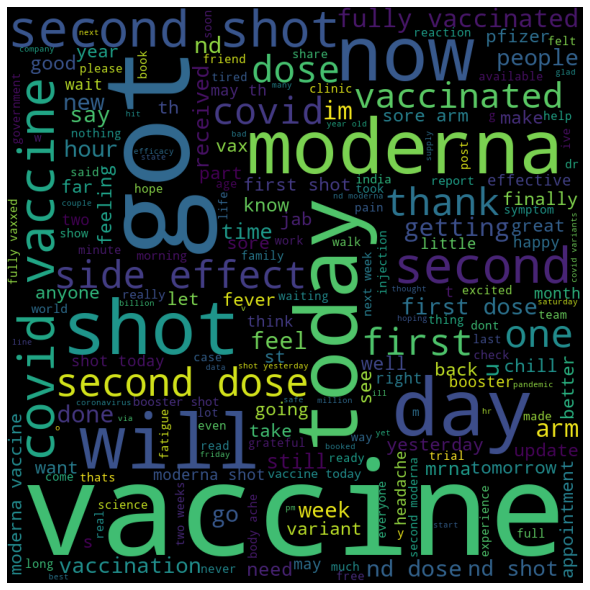

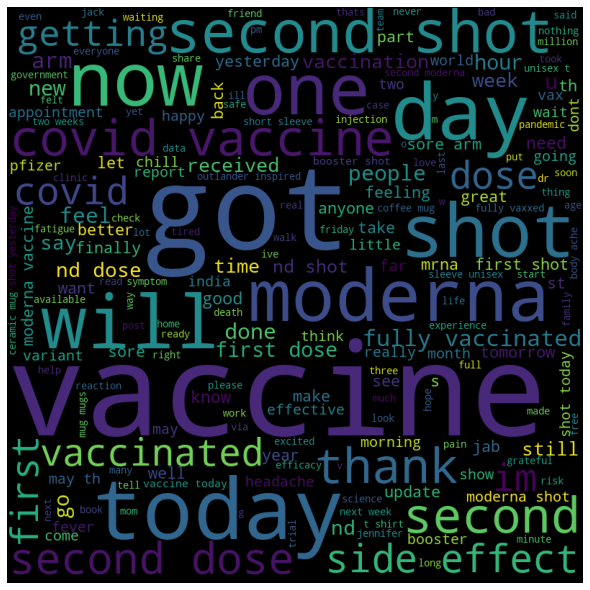

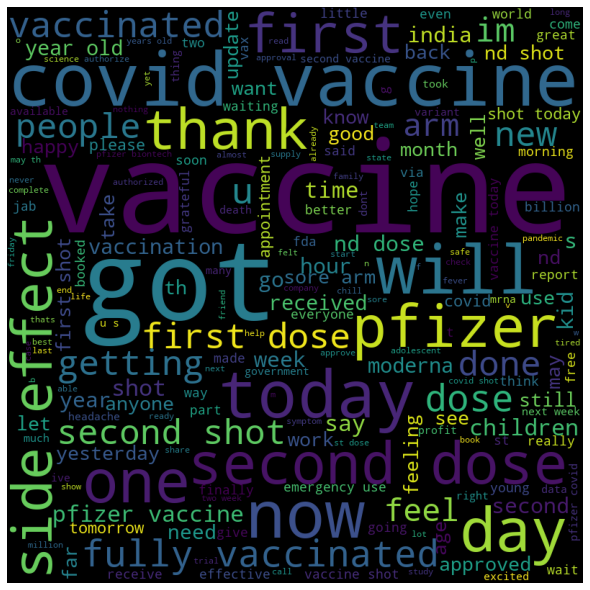

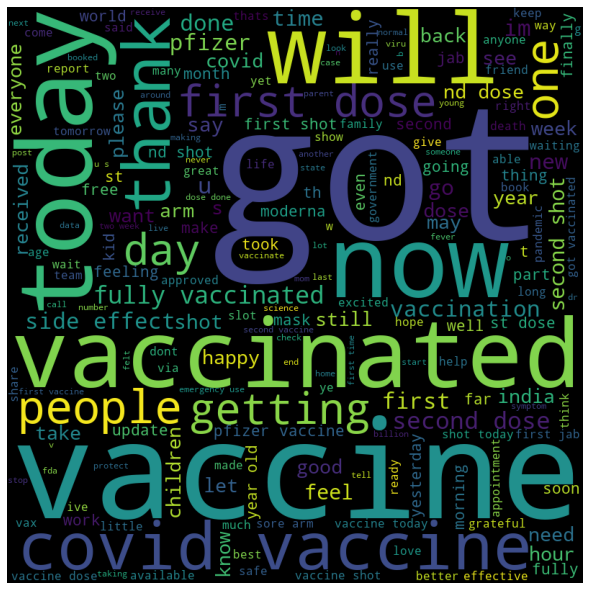

In [13]:
#worldcloud
#vaccinated
comment_words = ''
stopwords = set(STOPWORDS)
for topic in topics:
    for val in result_copy[topic].values:
        row = val[7]
        # print(row)
        tokens = row.split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()